In [4]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import networkx as nx
from scipy.spatial import cKDTree
import random

# Constants
D_MAX = 110           # Maximum distance for co-location (meters)
P_INF = 0.1           # Infection probability
TIME_WINDOW = 3600    # Time window for co-location (seconds)
INITIAL_INFECTED = 0.01  # Initial fraction of infected nodes
#SAMPLING_PROPORTIONS = np.array([0.025, 0.05, 0.1, 0.2])  # Sampling proportions (0.025, 0.05, 0.1, 0.2)

# STEP 1: Load the Gowalla dataset
file_path = 'loc-gowalla_totalCheckins.txt/Gowalla_totalCheckins.txt'  # Replace with your dataset path

# Define column names based on Gowalla dataset format
columns = ['user_id', 'timestamp', 'latitude', 'longitude', 'location_id']

# Load the dataset
gowalla_data = pd.read_csv(file_path, sep='\t', names=columns, parse_dates=['timestamp'])
print("Dataset Loaded Successfully!")


Dataset Loaded Successfully!


In [5]:
days_to_keep = 25
# 指定起始日期
start_date = pd.Timestamp('2010-05-22 02:49:04+00:00')

# 往后读取25天的数据
end_date = start_date + pd.DateOffset(days=days_to_keep)
gowalla_data = gowalla_data[gowalla_data['timestamp'] >= start_date]
gowalla_data = gowalla_data[gowalla_data['timestamp'] <= end_date]

In [10]:
# Sampling

# Define the sampling rates
sampling_rates = [0.2, 0.1, 0.05, 0.025]
sampled_dataset = {}

for rate in sampling_rates:
    sampled_data = gowalla_data.groupby('user_id').filter(lambda x: random.random() < rate)
    sampled_dataset[rate] = sampled_data
        
for i in sampling_rates:
    print("Sampling with rate", i)

Sampling with rate 0.2
Sampling with rate 0.1
Sampling with rate 0.05
Sampling with rate 0.025


In [11]:
# Output files to store sampled data
output_files = ['sampled_output_0.2.txt', 'sampled_output_0.1.txt', 'sampled_output_0.05.txt', 'sampled_output_0.025.txt']

for rate, sampled_data in sampled_data_frames.items():
    output_file = f'sampled_output_{rate}.txt'
    with open(output_file, 'w') as output:
        for index, row in sampled_data.iterrows():
            output_line = '\t'.join([str(row['user_id']), str(row['timestamp']), str(row['latitude']), str(row['longitude']), str(row['location_id'])]) + '\n'
            output.write(output_line)
    print("Writing to file completed:", output_file)

Writing to file completed: sampled_output_0.2.txt
Writing to file completed: sampled_output_0.1.txt
Writing to file completed: sampled_output_0.05.txt
Writing to file completed: sampled_output_0.025.txt


In [12]:
def build_contact_network_optimized(data, d_max=D_MAX, time_window=TIME_WINDOW):
    """
    Build a co-location graph using spatial and temporal optimizations.
    """
    G = nx.Graph()

    # Sort data by timestamp for efficient grouping
    data = data.sort_values(by='timestamp')

    # Group data into time windows
    min_time = data['timestamp'].min()
    data['time_bucket'] = ((data['timestamp'] - min_time).dt.total_seconds() // time_window).astype(int)
    grouped = data.groupby('time_bucket')

    # Process each time bucket
    for _, group in grouped:
        # Create a KDTree for spatial indexing within the current time window
        coords = group[['latitude', 'longitude']].values
        user_ids = group['user_id'].values
        tree = cKDTree(coords)

        # Find all pairs of users within the distance threshold
        pairs = tree.query_pairs(d_max / 1000)  # Convert meters to kilometers for KDTree
        for i, j in pairs:
            user1, user2 = user_ids[i], user_ids[j]
            G.add_edge(user1, user2)

    return G

contact_graph = build_contact_network_optimized(gowalla_data)
print("Contact Graph Generated Successfully!")

Contact Graph Generated Successfully!


In [13]:
# STEP 3: Simulate the ground truth spread
def simulate_ground_truth(G, p_inf, initial_infected=INITIAL_INFECTED):
    """Simulate SIR model for the ground truth."""
    infected = set(np.random.choice(list(G.nodes), int(len(G) * initial_infected), replace=False))
    susceptible = set(G.nodes) - infected
    true_spread = []

    while susceptible:
        new_infected = set()
        for u in susceptible:
            neighbors = set(G.neighbors(u))
            if any(np.random.rand() < p_inf for v in neighbors if v in infected):
                new_infected.add(u)
        if not new_infected:
            break
        infected |= new_infected
        susceptible -= new_infected
        true_spread.append(len(infected))
    return true_spread

true_spread = simulate_ground_truth(contact_graph, P_INF)
print("Ground Truth Simulated Successfully!")

Ground Truth Simulated Successfully!


In [14]:
# STEP 4: Implement the five methods
def scaling_method(sub_sample, total_population, p_s):
    """Simple scaling method."""
    return [len(sub_sample) / p_s for _ in range(len(total_population))]

print("finish scaling method")

finish scaling method


In [15]:
def location_modeling(contact_graph, p_inf, p_s, d_max):
    """Density-Based Location Modeling method."""
    infected_counts = []
    sampled_nodes = set(np.random.choice(list(contact_graph.nodes), int(len(contact_graph) * p_s), replace=False))
    observed_contacts = defaultdict(int)

    # Count contacts within sampled nodes
    for u in sampled_nodes:
        for v in contact_graph.neighbors(u):
            if v in sampled_nodes:
                observed_contacts[u] += 1

    # Estimate density and scale to the full population
    for _ in range(len(contact_graph)):
        estimated_infections = sum(p_inf * (count / p_s) for count in observed_contacts.values())
        infected_counts.append(estimated_infections)
    return infected_counts

print("finish location modeling")

finish location modeling


In [16]:
def poll_spreader(contact_graph, p_inf, initial_infected=INITIAL_INFECTED):
    """PollSpreader method."""
    infected = set(np.random.choice(list(contact_graph.nodes), int(len(contact_graph) * initial_infected), replace=False))
    infected_counts = []

    # Simulate first-hop infections
    for _ in range(len(contact_graph)):
        new_infected = set()
        for u in infected:
            for v in contact_graph.neighbors(u):
                if v not in infected and np.random.rand() < p_inf:
                    new_infected.add(v)
        infected.update(new_infected)
        infected_counts.append(len(infected))
    return infected_counts

print("finish poll-spreader")

finish poll-spreader


In [17]:
def poll_susceptible_upper(contact_graph, p_inf):
    """PollSusceptible Upper Bound method."""
    infected_counts = []
    susceptible = set(contact_graph.nodes)
    infected = set(np.random.choice(list(contact_graph.nodes), int(len(contact_graph) * 0.01), replace=False))

    # Upper bound assumption: every susceptible node gets infected by at least one neighbor
    for _ in range(len(contact_graph)):
        new_infected = set()
        for u in susceptible:
            for v in contact_graph.neighbors(u):
                if v in infected:
                    new_infected.add(u)
                    break
        infected.update(new_infected)
        susceptible -= new_infected
        infected_counts.append(len(infected))
    return infected_counts

print("finish poll-susceptible upper")

finish poll-susceptible upper


In [18]:
def poll_susceptible_lower(contact_graph, p_inf):
    """PollSusceptible Lower Bound method."""
    infected_counts = []
    susceptible = set(contact_graph.nodes)
    infected = set(np.random.choice(list(contact_graph.nodes), int(len(contact_graph) * 0.01), replace=False))

    # Lower bound assumption: minimal independent paths contribute to infections
    for _ in range(len(contact_graph)):
        new_infected = set()
        for u in susceptible:
            infected_neighbors = [v for v in contact_graph.neighbors(u) if v in infected]
            if infected_neighbors and np.random.rand() < p_inf:
                new_infected.add(u)
        infected.update(new_infected)
        susceptible -= new_infected
        infected_counts.append(len(infected))
    return infected_counts

print("finish poll-susceptile lower")

finish poll-susceptile lower


In [19]:
# STEP 5: Evaluate bias for each sampling proportion
method_biases = {method: [] for method in ["Scaling", "Location Modeling", "PollSpreader",
                                           "PollSusceptible Upper", "PollSusceptible Lower"]}

# Iterate over sampling proportions
for p_s in sampling_rates:
    sub_sample = sampled_dataset[p_s]
    sample_contact_graph = build_contact_network_optimized(sub_sample)
    scaling_results = scaling_method(sub_sample, list(sample_contact_graph.nodes), p_s)
    print("finish scaling")
    location_modeling_results = location_modeling(sample_contact_graph, P_INF, p_s, D_MAX)
    print("finish location modeling")
    poll_spreader_results = poll_spreader(sample_contact_graph, P_INF)
    print("finish poll_spreader")
    poll_susceptible_upper_results = poll_susceptible_upper(sample_contact_graph, P_INF)
    print("finish poll_susceptible_upper")
    poll_susceptible_lower_results = poll_susceptible_lower(sample_contact_graph, P_INF)
    print("finish poll_susceptible_lower")

    # Calculate bias for each method
    method_biases["Scaling"].append(np.mean([(est - true) / true for est, true in zip(scaling_results, true_spread)]))
    method_biases["Location Modeling"].append(np.mean([(est - true) / true for est, true in zip(location_modeling_results, true_spread)]))
    method_biases["PollSpreader"].append(np.mean([(est - true) / true for est, true in zip(poll_spreader_results, true_spread)]))
    method_biases["PollSusceptible Upper"].append(np.mean([(est - true) / true for est, true in zip(poll_susceptible_upper_results, true_spread)]))
    method_biases["PollSusceptible Lower"].append(np.mean([(est - true) / true for est, true in zip(poll_susceptible_lower_results, true_spread)]))
print("finish methods")

finish scaling
finish location modeling
finish poll_spreader
finish poll_susceptible_upper
finish poll_susceptible_lower
finish scaling
finish location modeling
finish poll_spreader
finish poll_susceptible_upper
finish poll_susceptible_lower
finish scaling
finish location modeling
finish poll_spreader
finish poll_susceptible_upper
finish poll_susceptible_lower
finish scaling
finish location modeling
finish poll_spreader
finish poll_susceptible_upper
finish poll_susceptible_lower
finish methods


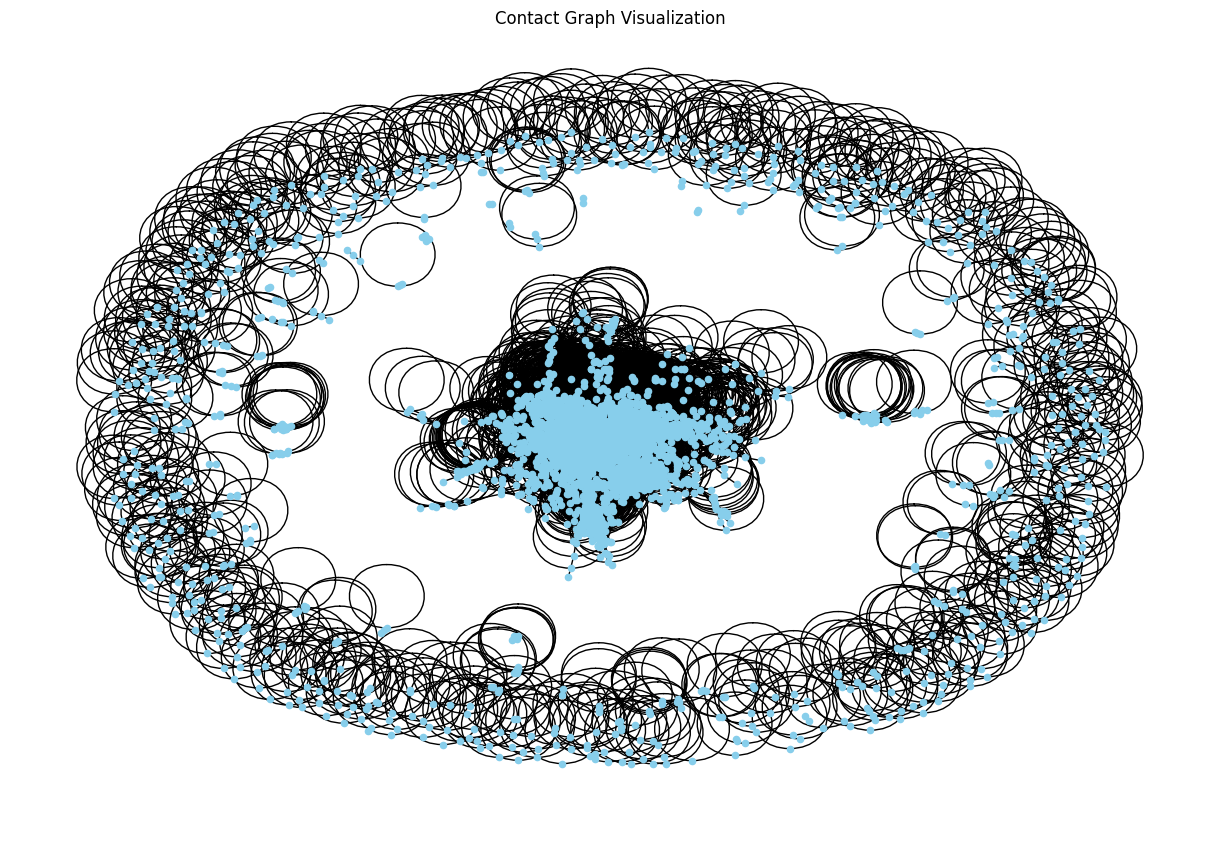

In [25]:
samplegra = sampled_dataset[0.2]
samplegra_contact_graph = build_contact_network_optimized(samplegra)
# 创建一个图形布局，这里使用Spring布局
pos = nx.spring_layout(samplegra_contact_graph)

# 绘制图形
plt.figure(figsize=(12, 8))
nx.draw(samplegra_contact_graph, pos, node_size=20, node_color='skyblue', with_labels=False)
plt.title('Contact Graph Visualization')
plt.show()

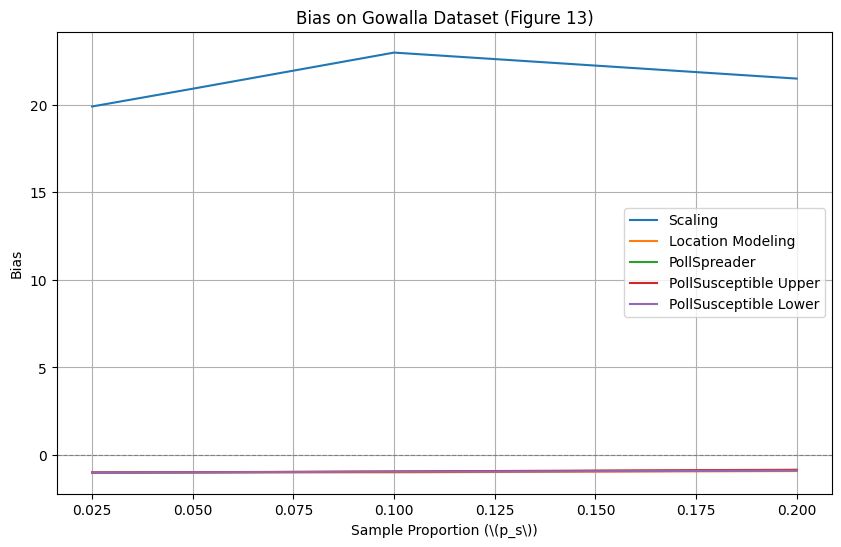

In [22]:

# STEP 6: Plot the results
plt.figure(figsize=(10, 6))
for method, biases in method_biases.items():
    plt.plot(sampling_rates, biases, label=method)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel("Sample Proportion (\\(p_s\\))")
plt.ylabel("Bias")
plt.title("Bias on Gowalla Dataset (Figure 13)")
plt.legend()
plt.grid(True)
plt.show()